In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os

from matplotlib import pyplot as plt

from metavision_core.event_io import RawReader

import lib

In [2]:
plt.rcParams['figure.figsize'] = [8, 6]

#### Loading the dataset

In [3]:
import numpy as np

dataset_path = "dataset/45/"

filenames = np.array(lib.load_filenames_to_matrix(dataset_path))

raws = []
for fxs in filenames:
	rawsx = [RawReader(f) for f in fxs]
	raws.append(rawsx)

distances = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 4.0, 5.0]
frequencies = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 20000, 30000]
bin_width_us = 1000

#### Get the events from raws

In [4]:
events = lib.recursive_map(lib.raw_load_events, raws, dtime=1000000, start_ts=0.1 * 1e6)

#### Process the data

In [7]:
#check if exists "avg_events.npy (precomputed) - takes a long time to compute"
avg_events_array = None

if os.path.exists("avg_events.npz"):
	k = ['avg_events_array_45', 'std_events_array_45', 'avg_events_array_0', 'std_events_array_0']
	npzfile = np.load("avg_events.npz")
	avg_events_array_45 = npzfile[k[0]]
	std_events_array_45 = npzfile[k[1]]
	avg_events_array_0 = npzfile[k[2]]
	std_events_array_0 = npzfile[k[3]]

else:
	avg_events_matrix = []
	std_events_matrix = []

	for distance_idx, event_list in enumerate(events):
		distance_avg_events = []
		distance_std_events = []
		print(f"Processing distance {distances[distance_idx]} meters")
		for freq_idx, event_set in enumerate(event_list):
			frequency = frequencies[freq_idx]
			
			if len(event_set) == 0:
				print(f"  No events for frequency {frequency} Hz")
				distance_avg_events.append(np.nan)  #NaN for missing data
				continue
			
			#if needs to be adjusted
			prominence_value = None
			
			#event data processing
			vals_dict = lib.process_event_data(
				event_set,
				frequency,
				prominence_value=prominence_value
			)

			avg_events, std_events, event_counts, signal, time_axis, peak_indices = vals_dict.values()
			
			print(f"  Frequency: {frequency} Hz, Average Events per Period: {avg_events}")
			
			distance_avg_events.append(avg_events)
			distance_std_events.append(std_events)
			
			# plt.figure(figsize=(12, 6))
			# plt.plot(time_axis, signal)
			# plt.plot(time_axis[peak_indices], signal[peak_indices], 'rx')  # Mark peaks
			# plt.xlabel('Time (us)')
			# plt.ylabel('Summed Polarity')
			# plt.title(f'Distance {distances[distance_idx]} m, Frequency {frequency} Hz')
			# plt.show()
		
		avg_events_matrix.append(distance_avg_events)
		std_events_matrix.append(distance_std_events)

	avg_events_array = np.array(avg_events_matrix)
	std_events_array = np.array(std_events_matrix)

In [ ]:
#save the events array to npz
#load the _0 from the npz file

#avg_events_array_0 = np.load("avg_events_0.npz")["avg_events_array_0"]
#std_events_array_0 = np.load("avg_events_0.npz")["std_events_array_0"]

#np.savez("avg_events.npz", avg_events_array_45=avg_events_array, std_events_array_45=std_events_array, avg_events_array_0=avg_events_array_0, std_events_array_0=std_events_array_0)

### Plot the effect of distance

In [8]:
evs = avg_events_array_0
stdevs = std_events_array_0

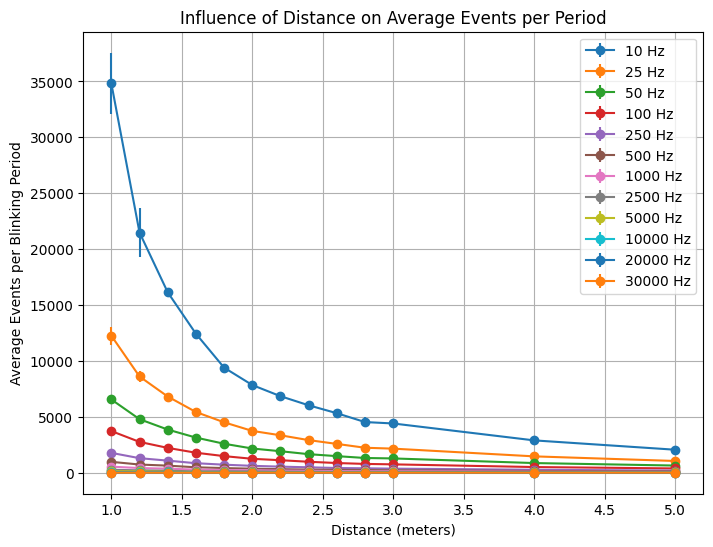

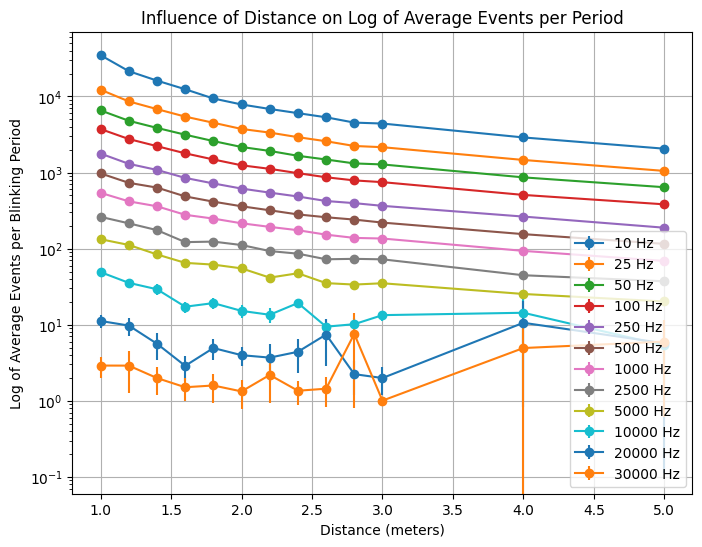

In [9]:
lib.plot_avg_events_vs_distance(distances, evs, stdevs, frequencies)
lib.plot_log_avg_events_vs_distance(distances, evs, stdevs, frequencies)

### Plot the effect of frequency

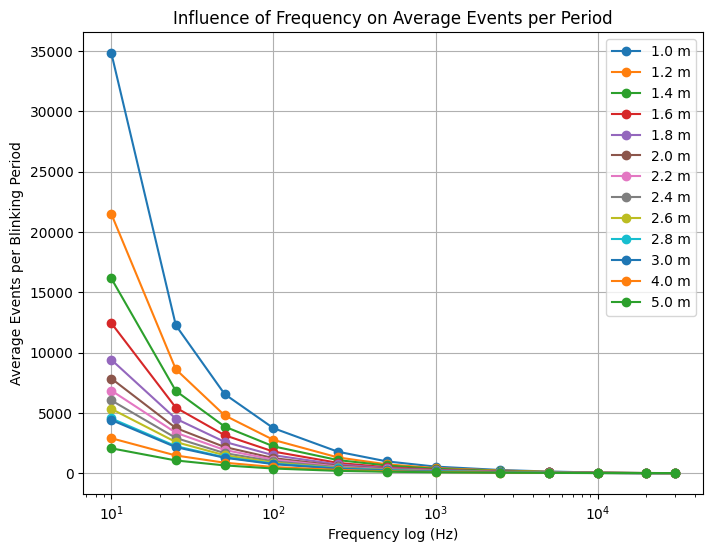

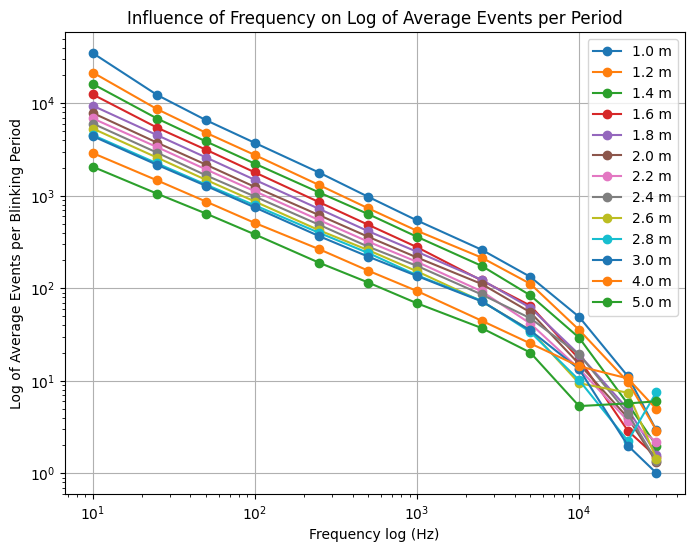

In [ ]:
lib.plot_avg_events_vs_frequency(frequencies, evs, distances)
lib.plot_log_avg_events_vs_frequency(frequencies, evs, distances)

#### Fitting a curve to the data

In [20]:
avg_events_array = avg_events_array_0.copy()

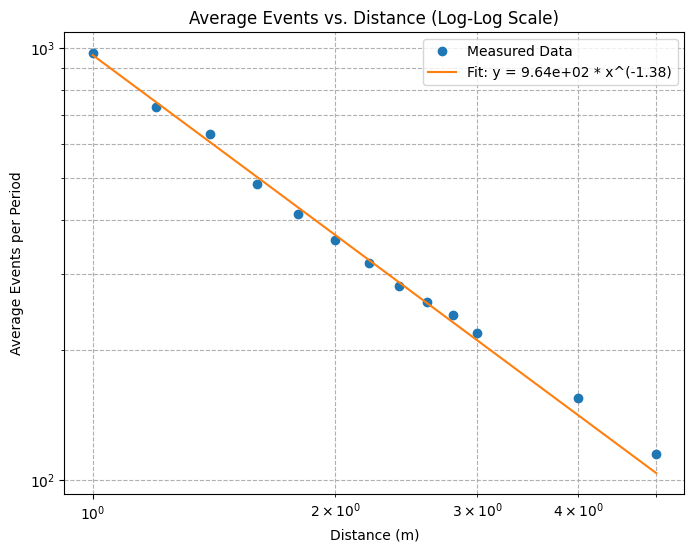

Fitted exponent n: 1.38


In [21]:
from scipy.optimize import curve_fit

avg_events_array = avg_events_array_0.copy()

def power_law(x, k, n):
	return k * x ** (-n)

distances_array = np.array(distances)

freq_idx = 5
avg_events = avg_events_array[:, freq_idx]

valid_indices = ~np.isnan(avg_events)
distances_valid = distances_array[valid_indices]
avg_events_valid = avg_events[valid_indices]

popt, pcov = curve_fit(power_law, distances_valid, avg_events_valid)
k_fit, n_fit = popt

plt.figure()
plt.loglog(distances_valid, avg_events_valid, 'o', label='Measured Data')
plt.loglog(distances_valid, power_law(distances_valid, *popt), '-', 
		   label=f'Fit: y = {k_fit:.2e} * x^(-{n_fit:.2f})')
plt.xlabel('Distance (m)')
plt.ylabel('Average Events per Period')
plt.title('Average Events vs. Distance (Log-Log Scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

print(f"Fitted exponent n: {n_fit:.2f}")

#### Fitting $y = c + b * x^{-2} - d * e^x$

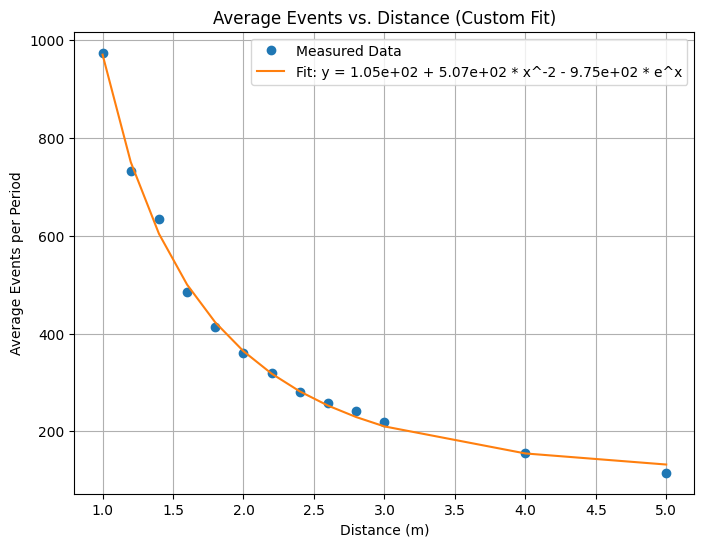

Fitted coefficients:
 c = 1.05e+02, b = 5.07e+02, d = 9.75e+02


In [35]:
distances_array = np.array(distances)
freq_idx = 5
avg_events = avg_events_array[:, freq_idx]

valid_indices = ~np.isnan(avg_events)
distances_valid = distances_array[valid_indices]
avg_events_valid = avg_events[valid_indices]

# matrix for the model y = c + b * x^2 + d * e^x
X = np.column_stack([
	np.ones_like(distances_valid),
	distances_valid**-2,
	np.exp(-distances_valid),
])

y = avg_events_valid

coefficients, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
c_fit, b_fit, d_fit = coefficients

y_fit = X @ coefficients

plt.figure()
plt.plot(distances_valid, avg_events_valid, 'o', label='Measured Data')
plt.plot(distances_valid, y_fit, '-', label=f'Fit: y = {c_fit:.2e} + {b_fit:.2e} * x^-2 - {d_fit:.2e} * e^x')
plt.xlabel('Distance (m)')
plt.ylabel('Average Events per Period')
plt.title('Average Events vs. Distance (Custom Fit)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted coefficients:\n c = {c_fit:.2e}, b = {b_fit:.2e}, d = {d_fit:.2e}")


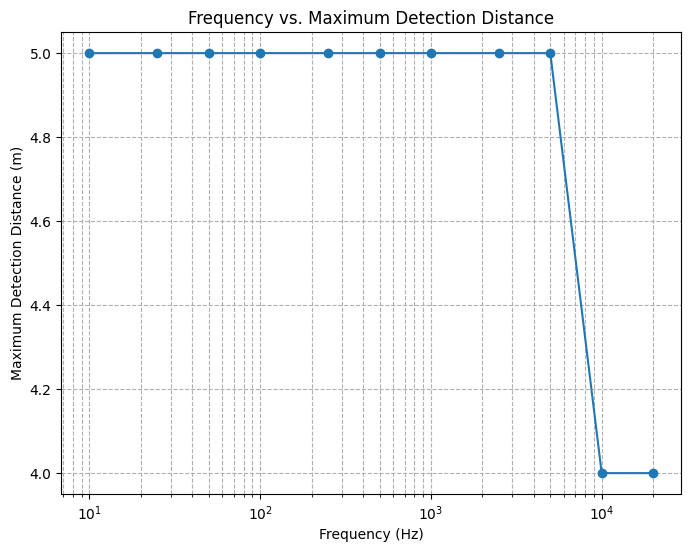

In [ ]:
max_distances = []

# this need some reajdustment
detection_threshold = 10

for freq_idx, frequency in enumerate(frequencies):
	avg_events_per_distance = avg_events_array[:, freq_idx]
	valid_indices = np.where(avg_events_per_distance > detection_threshold)[0]

	if valid_indices.size > 0:
		max_distance = distances[valid_indices[-1]]
		max_distances.append(max_distance)
		
	else:
		max_distances.append(np.nan)

plt.figure()
plt.plot(frequencies, max_distances, 'o-')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Maximum Detection Distance (m)')
plt.title('Frequency vs. Maximum Detection Distance')
plt.grid(True, which="both", ls="--")
plt.show()